# Unit 2
Unit 2 is divided into two parts -- 1st part consist of Finetuning and guiding while the 2nd part is Class conditioned Diffusion model Index.

## Part 2 - Fine-Tuning and Guidance

Fine-Tuning is re-training the existing model on new data to change the type of output they produce.
Guidance is controlling the output by steering the generation process at inference time for existing model.

Now the first is to first login to the huggingface_hub with access token.

In [1]:
from huggingface_hub import notebook_login

notebook_login()

### Importing the important packages

In [12]:
# numpy is for creating matrices or array
import numpy as np
# torch is the framework used for representing data and creating models
import torch
import torch.nn.functional as f
import torchvision
# dataset packages is used for loading data
from datasets import load_dataset
# DDIMScheduler and DDPMPipeline are packages used for scheduling noise and creating pipeline respectively.
from diffusers import DDIMScheduler, DDPMPipeline
# matplotlib is useful for repressing graphs and images
import matplotlib.pyplot as plt
# Pillow or PIL is for printing images
from PIL import Image
# transforms is for data augmentation
from torchvision import transforms
# tqdm is for showing progress bars
from tqdm.auto import tqdm

device = ("cuda" if torch.cuda.is_available() else "cpu")

### Loading a Pre-Trained Pipeline

Now I will load a pre trained pipleine of celebahq by google. Later on this pipeline will be used for fine-tuning.

In [3]:
image_pipe=DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

diffusion_pytorch_model.safetensors not found


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.18.2",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

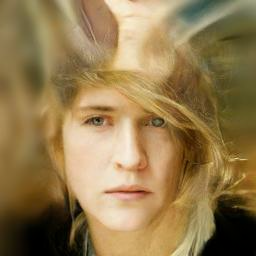

In [5]:
images = image_pipe().images
images[0]

DDPMScheduler is quite good but considered slow in inference. It is found that using 1000 steps for inferencing is unnecessary. To decrease the Sampling time, DDIMScheduler or Denoising Diffusion Implicit Models is introduced.
In DDPM, model is fed a noisy input at every step and asked to predic the noise. But in case for DDIM, we skip some steps thus covering more steps at a time.

In [4]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [7]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

As we can see, instead of going step by step each time DDIM takes 25 steps at a time thus covering 1000 steps in just 40 steps. 

0it [00:00, ?it/s]

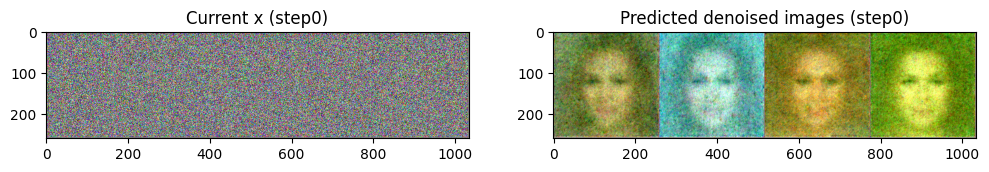

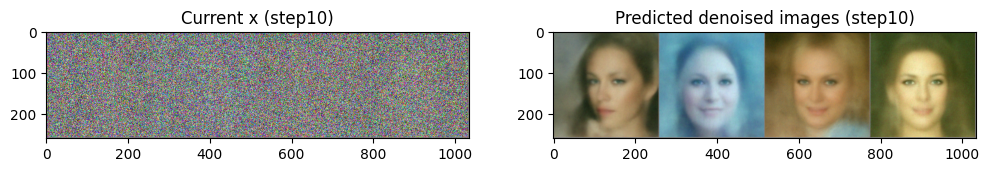

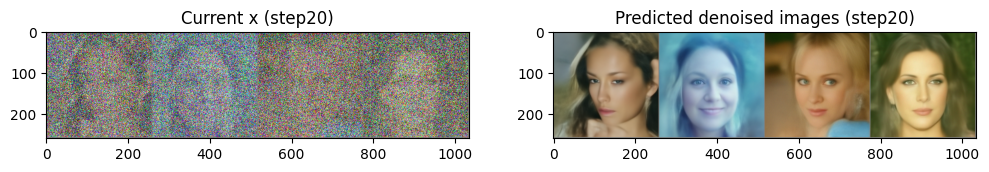

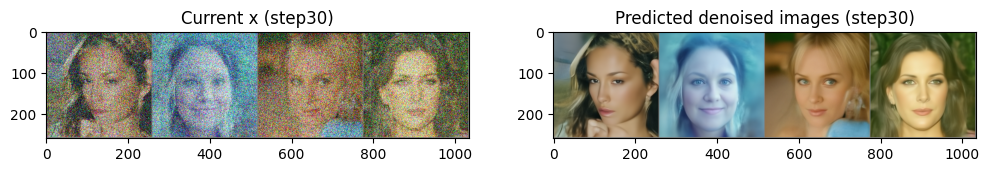

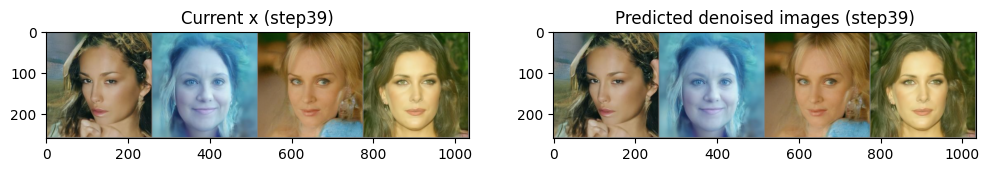

In [10]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device) # Batch of 4, 3 channel and 256 x 256 pixels

# Looping through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Preparing model input
    model_input = scheduler.scale_model_input(x, t)

    # Getting the Prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculating the output with scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Updating X
    x = scheduler_output.prev_sample

    # Printing both x and predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axis = plt.subplots(1, 2, figsize=(12, 15))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axis[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axis[0].set_title(f"Current x (step{i})")

        pred_x0 = (scheduler_output.pred_original_sample)
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axis[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axis[1].set_title(f"Predicted denoised images (step{i})")
        plt.show()

As we can see DDIM can predicts faster.

### Fine-Tuning

Now comes the fine tuning part. In this section, I am going to fine tune the current pipeline on the dataset of Anime Faces (https://www.kaggle.com/datasets/splcher/animefacedataset). I will be using first 1000 images of this dataset. I have already downloaded the data and I will be loading the data from my computer.

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/mkbha/.cache/huggingface/datasets/imagefolder/default-32333280458f5db8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Previewing batch:


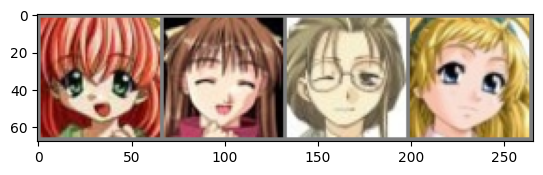

In [5]:
import os
dataset_path = os.path.join("dataset", "images")
dataset = load_dataset("imagefolder", data_dir=dataset_path, split="train")
image_size = 64
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/250 [00:00<?, ?it/s]

d:\AIProjects\StableDiffusionHF\diffusion\lib\site-packages\diffusers\configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.03173298224702012


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.031851676429621875


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 average loss: 0.028071247204672547


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3 average loss: 0.025693848656257616


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4 average loss: 0.02567361591535155


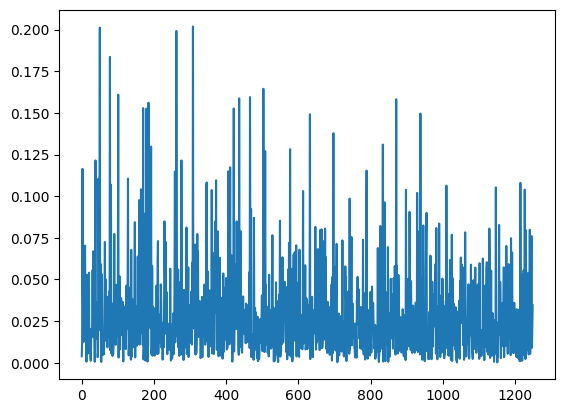

In [6]:
# Training loop

num_epochs = 5
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sampling noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps= torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs, ),
            device=clean_images.device,
        ).long()

        # Adding noise to the clean images according to the noise magnitude at each timesteps
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Getting the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculating loss
        loss = f.mse_loss(
            noise_pred, noise
        )

        # Storing for plotting
        losses.append(loss.item())

        # Updating the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Ploting the loss curve:
plt.plot(losses)
     

The loss graph is very noisy, I have tried tweeking learning rate and grad_accumulation_steps in order to reduce the noise of the loss. The other causes for the noise can be the incompatibility of the datasets. Because of which the model is having a hard time learning the pattern of the images.

0it [00:00, ?it/s]

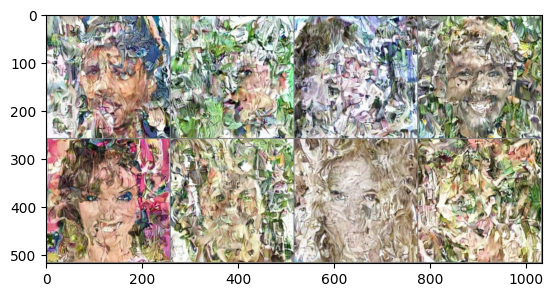

In [7]:
# Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

The images created from fine-tuned pipeline look nothing like a proper face or anime face though they still look quite artistic in my opinion. The cause of these photos can be due to less training. Or also the noisy training. There is also a factor that the pipeline is trained on images of 256*256 pixels but the size of anime faces is of 64 pixels. Due to 6 gb of VRAM in the graphics card. The model wasn't able to be trained on 256 pixels.

  0%|          | 0/1000 [00:00<?, ?it/s]

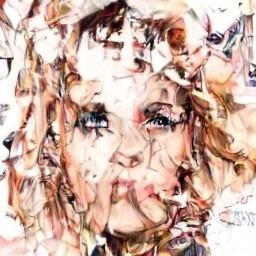

In [22]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [8]:
image_pipe.save_pretrained("my-finetuned-model")

In [9]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-celebahq-finetuned-anime-5epochs"  
local_folder_name = "my-finetuned-model"  
description = "This is a celebahq sd model fine-tuned with anime faces dataset." 
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

'https://huggingface.co/Hawk91/ddpm-celebahq-finetuned-anime-5epochs/blob/main/README.md'

### Guidance

Guidance is a technique to gain additional control over the photo. For example, if we want to bias the generated images to be a specific color then it can be done through guidance. We can understand that guidance is to guide the generation of image to a desired output.



In [10]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    '''Given a target color(R, G, B) return a loss for how far away on average 
    the images' pixels are from that color. Defaults to the light teal: (0.1, 0.9, 0.5)'''
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    ) # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ] # Get shape right to work with images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()
    return error

The next step is to modify the sampling loop
- Create a new version of x that has requires_grad = True.
- Calculate the denoised version(x0)
- Feed the predicted x0 through loss function
- Find the gradient of this loss funciton with respect to x
- Use this conditioning gradient to modify x before we step with the scheduler.

There are two variants to explore. First is to set required_grad on x after getting the noise prediction. This is memory efficient since there is no need to trace gradient back through the diffusion model but it lacks accuracy. The second variant is to apply required_grad on x first, then feed it to the unet to calculate prediction.

0it [00:00, ?it/s]

0 loss: 31.80340576171875
10 loss: 18.138273239135742
20 loss: 17.922958374023438
30 loss: 19.21413230895996


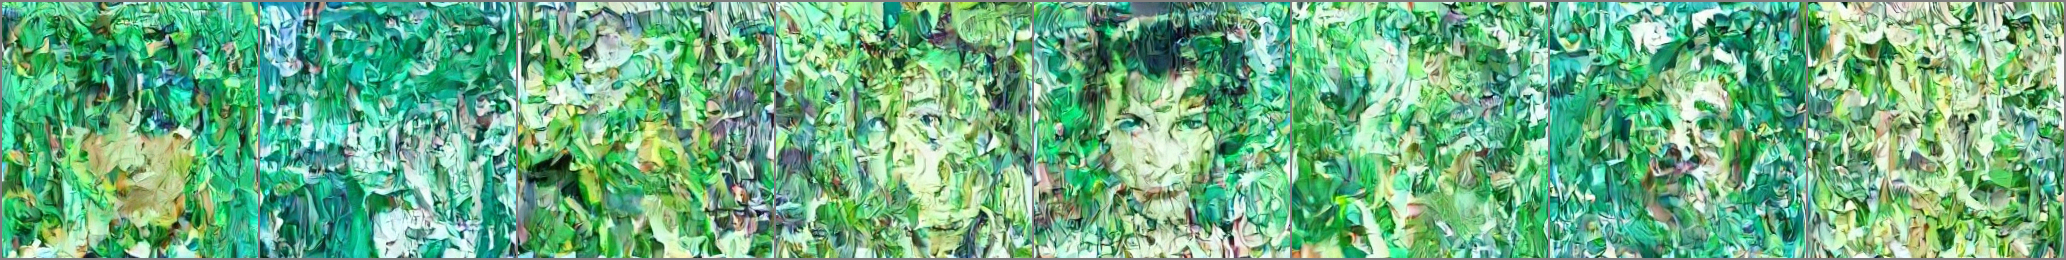

In [17]:
# Variact 1: Memory efficient

# guidance scale determines strength of the effect
guidance_loss_scale = 40

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Setting x.requires_grad to True
    x = x.detach().requires_grad_()

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modifying x based on this gradient
    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrows=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

0 loss: 84.06857299804688
10 loss: 10.511430740356445
20 loss: 12.677276611328125
30 loss: 16.56446075439453


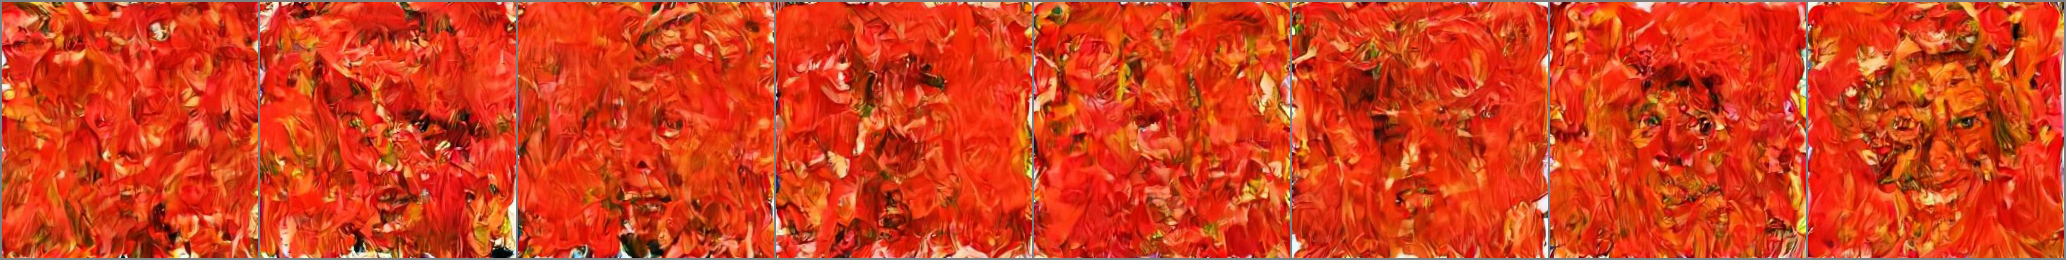

In [19]:

# guidance scale determines strength of the effect
guidance_loss_scale = 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Setting x.requires_grad to True
    x = x.detach().requires_grad_()

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0, (0.85, 0.24, 0.1)) * guidance_loss_scale # this is for Red like color
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modifying x based on this gradient
    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrows=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

0 loss: 13.252229690551758
10 loss: 8.641311645507812
20 loss: 8.527505874633789
30 loss: 8.718705177307129


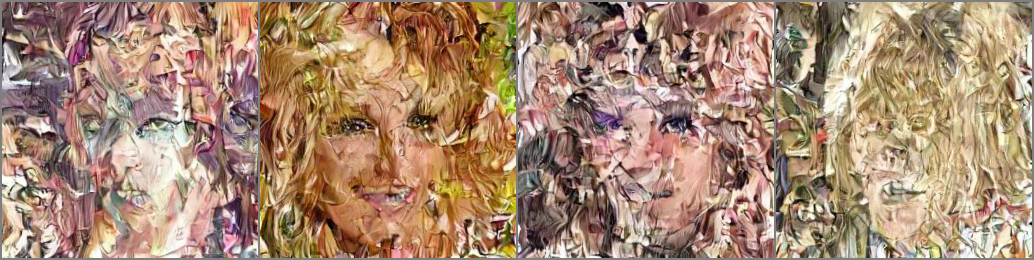

In [21]:
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 15
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0, (0.85, 0.24, 0.1)) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

0 loss: 33.37639617919922
10 loss: 20.918270111083984
20 loss: 20.911945343017578
30 loss: 22.034343719482422


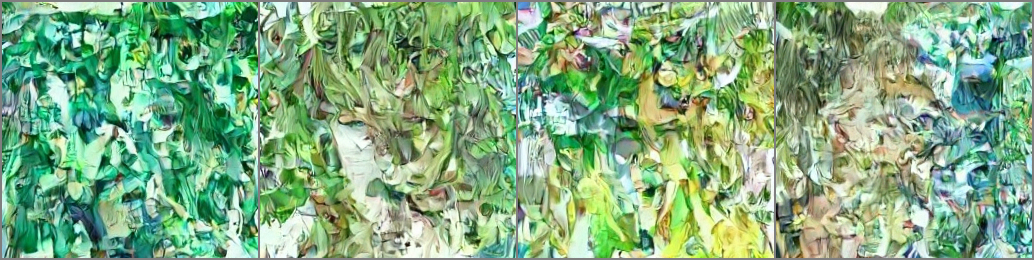

In [22]:
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

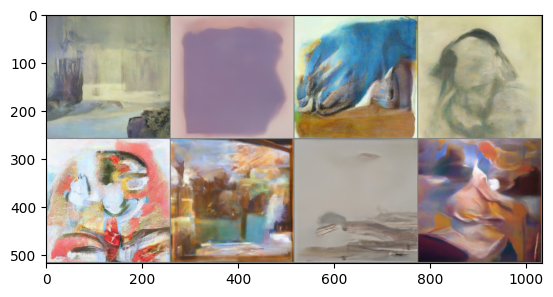

In [3]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

### CLIP Guidance

CLIP is a model created by OpenAI that allow us to compare images to text captions. So instead of giving color coordinates, We can just write how we want to guide the generated image. 

The basic functioning of OpenCLIP is given as:
- Text Prompt gets embeded to get a 512-dimensional CLIP embedding of the text
- For every step of diffusion model process:
    - Make several variants of predicted denoised images
    - embed the image with CLIP and compare this embedding with text embedding of the prompt ('Great Circle Distance Squared')
- Then calculate the gradient of this loss with respect to the noisy x and use this gradient to modify x before updating it with the scheduler.

In [6]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

#Transforms to resize and augment an image and normalize to match CLIP's training data
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224), # Randome CROP each time
        torchvision.transforms.RandomAffine(
            5
        ), # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        transform(image)
    )
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    ) # Squared Great Circle Distance
    return dists.mean()

0it [00:00, ?it/s]

Step: 0 , Guidance loss: 22.18214988708496
Step: 25 , Guidance loss: 20.865928649902344


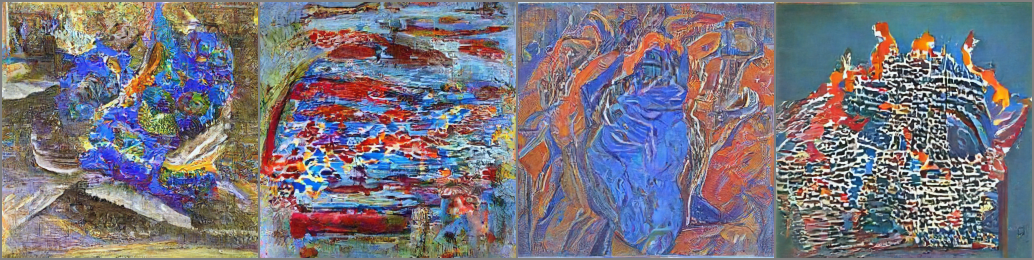

In [10]:
prompt = "Blue Fire painting"

guidance_scale = 25
n_cuts = 4

# more timesteps means more time for guidance to have an effect
scheduler.set_timesteps(50)

# Embedding the prompt with CLIP as target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_feature = clip_model.encode_text(text)

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        x = x.detach().requires_grad_()

        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        loss = clip_loss(x0, text_feature) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modifying x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i] # Cummulative product of alphas, returns a tensor
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Here we can see that is blue in every photo. First pic look very much like a bed caught on blue fire.

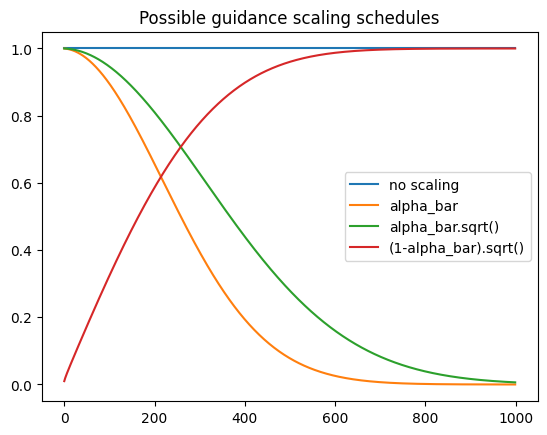

In [11]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot(
    [(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()"
)
plt.legend()
plt.title("Possible guidance scaling schedules");

### Gradio Demo

In [ ]:
import gradio as gr
from PIL import Image, ImageColor

def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    '''Given a target color(R, G, B) return a loss for how far away on average 
    the images' pixels are from that color. Defaults to the light teal: (0.1, 0.9, 0.5)'''
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    ) # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ] # Get shape right to work with images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()
    return error

# The function that does the hard work
def generate(color, guidance_loss_scale):
    target_color = ImageColor.getcolor(color, "RGB")  # Target color as RGB
    target_color = [a / 255 for a in target_color]  # Rescale from (0, 255) to (0, 1)
    x = torch.randn(1, 3, 256, 256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im


# See the gradio docs for the types of inputs and outputs available
inputs = [
    gr.ColorPicker(label="color", value="#55FFAA"),  # Add any inputs you need here
    gr.Slider(label="guidance_scale", minimum=0, maximum=30, value=3),
]
outputs = gr.Image(label="result")

# And the minimal interface
demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],  # You can provide some example inputs to get people started
    ],
)
demo.launch(debug=True)  # debug=True allows you to see errors and output in Colab

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]